<a href="https://colab.research.google.com/github/RadwaTareq/face_poses_prediction_model/blob/main/face_poses_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Thanks to:
- Amira Adel Foda (intake 42 - smart village branch - group 2)
- Asmaa Said (intake 42 - smart village branch - group 2)
- Marawan Mohamed (intake 42 - Alex. branch - group 2)


### Installing MediaPipe

In [1]:
%%capture
!pip install mediapipe

### Required Libraries

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
import scipy.io as sio
from pathlib import Path
from google.colab.patches import cv2_imshow
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import joblib
from moviepy.editor import VideoFileClip
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Dowlining Data

In [3]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [4]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [6]:
faceModule = mediapipe.solutions.face_mesh
data_path='/content/AFLW2000/'
dfdata = pd.DataFrame(columns=[f'mark_{i}' for i in range(1, 937)])
with faceModule.FaceMesh(static_image_mode=True) as faces:
  for filename in os.listdir(data_path):
    if filename.lower().endswith(('.jpg')):
        # Load the image
        image_path = os.path.join(data_path, filename)
        image = cv2.imread(image_path)
        # loading the image
        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
          # looping over the faces in the image
          imagexy=[]
          for face in results.multi_face_landmarks:
              for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                  shape = image.shape
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  imagexy.append(x)
                  imagexy.append(y)
                  # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                  cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
          dfdata = dfdata.append(pd.Series(imagexy, index=dfdata.columns), ignore_index=True)
        # cv2_imshow(image)
        # print(image)
print(dfdata.shape)

(1853, 936)


In [7]:
dfdata.head()

mark_1    mark_2    mark_3    mark_4    mark_5    mark_6    mark_7  \
0  0.571375  0.673056  0.584117  0.603582  0.556531  0.627546  0.535487   
1  0.532176  0.667673  0.535371  0.598976  0.529377  0.621830  0.505956   
2  0.447993  0.649642  0.437458  0.590813  0.455264  0.611940  0.449053   
3  0.443864  0.672992  0.413072  0.598421  0.451919  0.627388  0.434505   
4  0.513728  0.680252  0.532369  0.616162  0.518393  0.636811  0.511478   

     mark_8    mark_9   mark_10  ...  mark_927  mark_928  mark_929  mark_930  \
0  0.539906  0.583344  0.582244  ...  0.524697  0.459673  0.523450  0.469041   
1  0.527836  0.534440  0.575715  ...  0.558106  0.473474  0.548424  0.478275   
2  0.541334  0.438372  0.574770  ...  0.539161  0.511185  0.527872  0.514170   
3  0.536252  0.412093  0.576507  ...  0.548012  0.480369  0.533444  0.486946   
4  0.547175  0.535111  0.594902  ...  0.554239  0.499678  0.546748  0.504098   

   mark_931  mark_932  mark_933  mark_934  mark_935  mark_936  
0  0.527885  0.475681  0.587631  0.430111  0.591458  0.414826  
1  0.544708  0.481212  0.654830  0.457834  0.664734  0.448598  
2  0.518058  0.516062  0.620978  0.512889  0.633617  0.506410  
3  0.519073  0.490849  0.632361  0.459159  0.647626  0.447413  
4  0.544611  0.507034  0.634735  0.499947  0.643617  0.489504  

[5 rows x 936 columns]

In [8]:
label_list = []

for filename in os.listdir(data_path):
    name = filename.split('.')[0]

    if filename.lower().endswith(('.jpg')):
      image = cv2.imread(os.path.join(data_path, name + '.jpg'))

      # loading the mat file to extract the 3 angles of the face (pitch, yaw, roll)
      mat_file = sio.loadmat(os.path.join(data_path, name + '.mat'))

      with faceModule.FaceMesh(static_image_mode=True) as faces:
          results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
          if results.multi_face_landmarks is not None:
              # Extracting the labels 3 angles
              pose_para = mat_file["Pose_Para"][0][:3]
              pitch = pose_para[0]
              yaw = pose_para[1]
              roll = pose_para[2]

              # Append to label_list
              label_list.append({'pitch': pitch, 'yaw': yaw, 'roll': roll})
labels = pd.DataFrame(label_list)
print(labels.shape)

(1853, 3)


In [9]:
labels

pitch       yaw      roll
0    -0.374258 -0.646212 -0.034842
1     0.141765 -0.131516 -0.109661
2     0.028077  0.529243  0.154636
3     0.113253  0.980143  0.026109
4    -0.113470 -0.141071  0.087060
...        ...       ...       ...
1848 -0.069056 -0.476953 -0.073886
1849  0.251028 -0.880350  0.110841
1850 -0.436715 -1.385543  0.642251
1851  0.106527 -0.003015 -0.019662
1852 -0.169911 -0.009994 -0.034470

[1853 rows x 3 columns]

In [10]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

#splitting data


In [11]:
r_seed = 99
train_data, validation_test_data, labels_train, labels_validation_test = train_test_split(dfdata, labels, test_size=0.2, random_state=40)
validation_data, test_data, labels_validation, labels_test = train_test_split(validation_test_data, labels_validation_test, test_size=0.5, random_state=r_seed)
print('labels_train.shape = ', labels_train.shape)
print('labels_validation.shape = ', labels_validation.shape)
print('labels_test.shape = ', labels_test.shape)


labels_train.shape =  (1482, 3)
labels_validation.shape =  (185, 3)
labels_test.shape =  (186, 3)


#training different models

In [12]:
lasso_reg = linear_model.Lasso(alpha=0.0001, max_iter=10000)
lasso_reg.fit(train_data, labels_train)
print('LR model Lasso: ')
print('Train : ', lasso_reg.score(train_data, labels_train))
print('Validation : ', lasso_reg.score(validation_data, labels_validation))

LR model Lasso: 
Train :  0.4796388109865893
Validation :  0.6202509763974694


In [13]:
# ## LinearRegression Ridge ##
ridge_reg = Ridge(alpha=0.001, max_iter=10000)
ridge_reg.fit(train_data, labels_train)
print('LR model Ridge: ')
print('Train : ', ridge_reg.score(train_data, labels_train))
print('Validation : ', ridge_reg.score(validation_data, labels_validation))

LR model Ridge: 
Train :  0.6094019027828389
Validation :  0.5348787950151185


In [14]:
# ## ElasticNet Model ##
alpha = 0.001  # regularization strength
l1_ratio = 0.05  # mixing parameter for L1 and L2 penalties
elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=r_seed)
elastic_net.fit(train_data, labels_train)
print('Elastic Net model : ')
print('Train : ', elastic_net.score(train_data, labels_train))
print('Validation : ', elastic_net.score(validation_data, labels_validation))

Elastic Net model : 
Train :  0.46454154987100343
Validation :  0.6151933276621259


In [15]:
# ## Decision Tree ##
decTree = DecisionTreeRegressor(max_depth=20, min_samples_split=10, min_samples_leaf=10, random_state=r_seed)
decTree.fit(train_data, labels_train)
print('Decision Tree model : ')
print('Train : ', decTree.score(train_data, labels_train))
print('Validation : ', decTree.score(validation_data, labels_validation))


Decision Tree model : 
Train :  0.47231175343953513
Validation :  0.18501757337142108


In [16]:
# ## Random Forest ##
rf = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, random_state=r_seed)
rf.fit(train_data, labels_train)
print('Random Forest model : ')
print('Train : ', rf.score(train_data, labels_train))
print('Validation : ', rf.score(validation_data, labels_validation))

Random Forest model : 
Train :  0.8899477060067239
Validation :  0.7305185974713856


In [17]:
models = [lasso_reg, ridge_reg, elastic_net, rf, decTree]
for model in models:
    print(f'{model} Model\n')
    print('Test accuarcy : ', model.score(test_data, labels_test))
    print('_' * 100)

Lasso(alpha=0.0001, max_iter=10000) Model

Test accuarcy :  -0.7044586814788362
____________________________________________________________________________________________________
Ridge(alpha=0.001, max_iter=10000) Model

Test accuarcy :  -0.19435545761543058
____________________________________________________________________________________________________
ElasticNet(alpha=0.001, l1_ratio=0.05, random_state=99) Model

Test accuarcy :  -0.7359061894923716
____________________________________________________________________________________________________
RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=99) Model

Test accuarcy :  0.5119288302804066
____________________________________________________________________________________________________
DecisionTreeRegressor(max_depth=20, min_samples_leaf=10, min_samples_split=10,
                      random_state=99) Model

Test accuarcy :  -0.10405088607453077
__________________________________________________________________

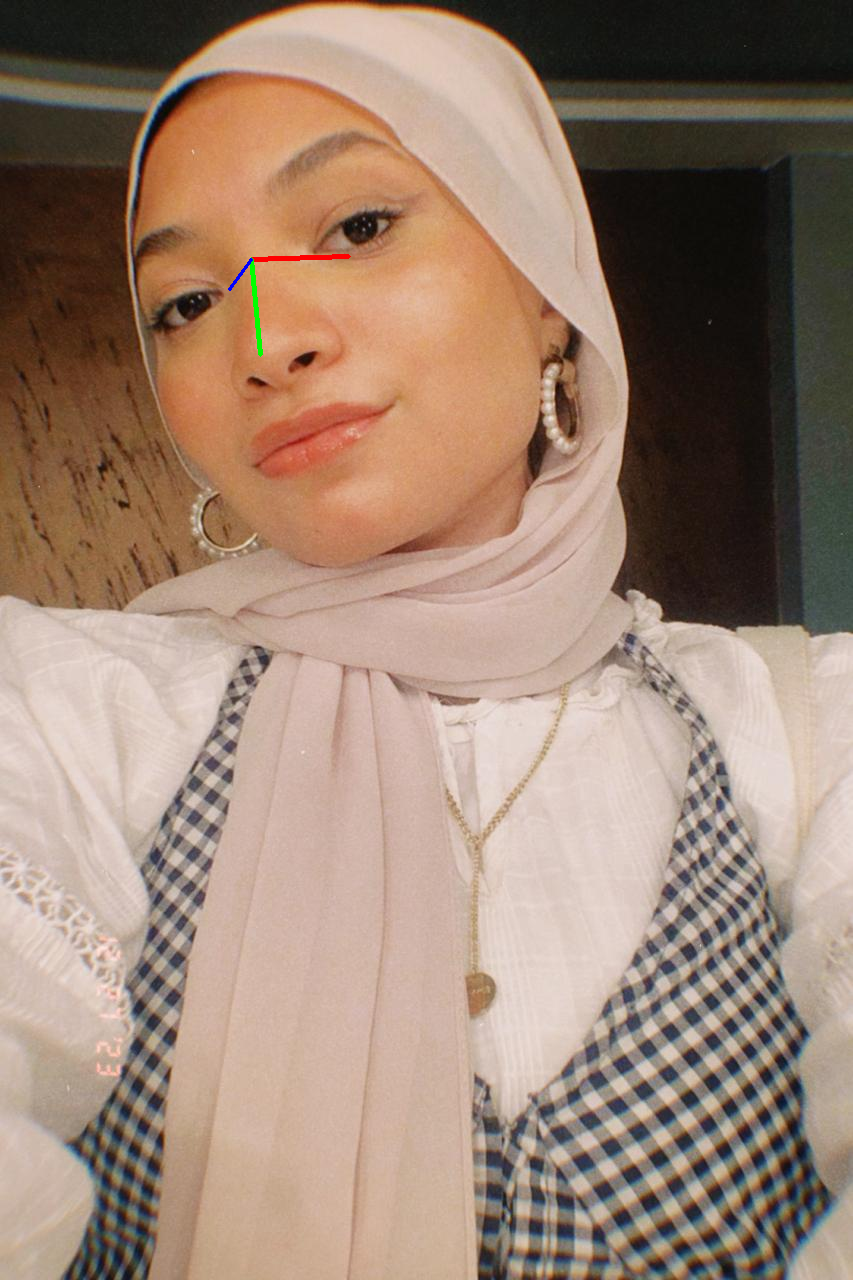

In [18]:
faceModule = mediapipe.solutions.face_mesh
df = pd.DataFrame(columns=[f'mark_{i}' for i in range(1, 937)])
image_path='/content/WhatsApp Image 2024-03-03 at 12.58.13 PM.jpeg'
with faceModule.FaceMesh(static_image_mode=True) as faces:
        image = cv2.imread(image_path)
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
          imagexy=[]
          pointx = []
          pointy = []
          for face in results.multi_face_landmarks:
              for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  shape = image.shape
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  imagexy.append(x)
                  imagexy.append(y)
                  pointx.append(x)
                  pointy.append(y)
                  # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                  # cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
          df = df.append(pd.Series(imagexy, index=df.columns), ignore_index=True)
# imgdata=preprocess(df)
x = df.iloc[:, ::2].values
y = df.iloc[:, 1::2].values
tdx=shape[1]*pointx[168]
tdy=shape[0]*pointy[168]
axis=rf.predict(df)
pitch = axis[0,0]
yaw = axis[0,1]
roll = axis[0,2]
cv2_imshow(draw_axis(image,pitch,yaw,roll,tdx=tdx, tdy=tdy))


In [19]:
video_path = "/content/vlc-record-2024-03-03-15h05m57s-vlc-record-2024-03-03-14h47m52s-Best Intro Ever - The Office US.mp4-.mp4-.mp4"
cap = cv2.VideoCapture(video_path)

mp_face_detection = mediapipe.solutions.face_detection
mp_face_mesh = mediapipe.solutions.face_mesh

face_detection = mp_face_detection.FaceDetection()
face_mesh = mp_face_mesh.FaceMesh()
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video_path = "output_video.avi"
output_video = cv2.VideoWriter(output_video_path, fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result_detection = face_detection.process(frame_rgb)

    if result_detection.detections:
        for detection in result_detection.detections:
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = frame.shape
            bbox = int(bboxC.xmin * iw), int(bboxC.ymin * ih),int(bboxC.width * iw), int(bboxC.height * ih)
            cv2.rectangle(frame, bbox, (255, 0, 255), 2)
    result_landmarks = face_mesh.process(frame_rgb)
    if result_landmarks.multi_face_landmarks:
        for face_landmarks in result_landmarks.multi_face_landmarks:
            landmarks = []
            for lm in face_landmarks.landmark:
                x, y = (lm.x), (lm.y)
                landmarks.append([x, y])
            landmarks_np = np.array(landmarks)
            x = landmarks_np[:, 0].reshape((1,-1))
            y = landmarks_np[:, 1].reshape((1,-1))
            x_y = np.hstack((x, y))
            x = x_y[:, :468]
            y = x_y[:, 468:]
            # x_normalized = ((x - np.min(x, axis=1, keepdims=True)) / (np.max(x, axis=1, keepdims=True) - np.min(x, axis=1, keepdims=True)))
            # y_normalized = ((y - np.min(y, axis=1, keepdims=True))  / (np.max(y, axis=1, keepdims=True) - np.min(y, axis=1, keepdims=True)))
            x_y = np.hstack((x, y))
            angles = rf.predict(x_y)
            pitch = angles[0,0]
            yaw = angles[0,1]
            roll = angles[0,2]
            draw_axis(frame, pitch, yaw, roll, tdx=x[0,168]*iw, tdy=y[0,168]*ih, size=100)
    output_video.write(frame)
    # cv2_imshow( frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
output_video.release()
cv2.destroyAllWindows()

#preprocessing data

In [20]:
def preprocess(data):
  x = data.iloc[:, ::2].values
  y = data.iloc[:, 1::2].values
  x_normalized = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))
  y_normalized = (y - np.min(y, axis=0)) / (np.max(y, axis=0) - np.min(y, axis=0))
  print("Normalized x shape:", x_normalized.shape)
  print("Normalized y shape:", y_normalized.shape)
  features = np.hstack((x_normalized, y_normalized))
  print("Reconstructed features shape:", features.shape)
  return features
normalized_train_data=preprocess(train_data)
normalized_valid_data=preprocess(validation_data)
normalized_test_data=preprocess(test_data)

Normalized x shape: (1482, 468)
Normalized y shape: (1482, 468)
Reconstructed features shape: (1482, 936)
Normalized x shape: (185, 468)
Normalized y shape: (185, 468)
Reconstructed features shape: (185, 936)
Normalized x shape: (186, 468)
Normalized y shape: (186, 468)
Reconstructed features shape: (186, 936)


In [21]:
lasso_reg = linear_model.Lasso(alpha=0.0001, max_iter=10000)
lasso_reg.fit(normalized_train_data, labels_train)
print('LR model Lasso: ')
print('Train : ', lasso_reg.score(normalized_train_data, labels_train))
print('Validation : ', lasso_reg.score(normalized_valid_data, labels_validation))

LR model Lasso: 
Train :  0.49562017026668387
Validation :  -8.758243118911365


In [22]:
# ## LinearRegression Ridge ##
ridge_reg = Ridge(alpha=0.001, max_iter=10000)
ridge_reg.fit(normalized_train_data, labels_train)
print('LR model Ridge: ')
print('Train : ', ridge_reg.score(normalized_train_data, labels_train))
print('Validation : ', ridge_reg.score(normalized_valid_data, labels_validation))

LR model Ridge: 
Train :  0.6511258198385934
Validation :  -1031.9303938927746


In [23]:
# ## ElasticNet Model ##
alpha = 0.001  # regularization strength
l1_ratio = 0.05  # mixing parameter for L1 and L2 penalties
elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=r_seed)
elastic_net.fit(normalized_train_data, labels_train)
print('Elastic Net model : ')
print('Train : ', elastic_net.score(normalized_train_data, labels_train))
print('Validation : ', elastic_net.score(normalized_valid_data, labels_validation))

Elastic Net model : 
Train :  0.47319899987016784
Validation :  -2.1818493111363035


In [24]:
# ## Decision Tree ##
decTree = DecisionTreeRegressor(max_depth=30, min_samples_split=10, min_samples_leaf=10, random_state=r_seed)
decTree.fit(normalized_train_data, labels_train)
print('Decision Tree model : ')
print('Train : ', decTree.score(normalized_train_data, labels_train))
print('Validation : ', decTree.score(normalized_valid_data, labels_validation))


Decision Tree model : 
Train :  0.47231175343953513
Validation :  -0.05986698491904108


In [25]:
# ## Random Forest ##
rf = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, random_state=r_seed)
rf.fit(normalized_train_data, labels_train)
print('Random Forest model : ')
print('Train : ', rf.score(normalized_train_data, labels_train))
print('Validation : ', rf.score(normalized_valid_data, labels_validation))

Random Forest model : 
Train :  0.8893521352416345
Validation :  -1.421436707785792


#testing all models on normalized test data   

In [26]:
models = [lasso_reg, ridge_reg, elastic_net, rf, decTree]
for model in models:
    print(f'{model} Model\n')
    print('Test accuarcy : ', model.score(normalized_test_data, labels_test))
    print('_' * 100)

Lasso(alpha=0.0001, max_iter=10000) Model

Test accuarcy :  -25.520040006163942
____________________________________________________________________________________________________
Ridge(alpha=0.001, max_iter=10000) Model

Test accuarcy :  -292.7371514655427
____________________________________________________________________________________________________
ElasticNet(alpha=0.001, l1_ratio=0.05, random_state=99) Model

Test accuarcy :  -21.3358632594603
____________________________________________________________________________________________________
RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=99) Model

Test accuarcy :  -15.862110372822473
____________________________________________________________________________________________________
DecisionTreeRegressor(max_depth=30, min_samples_leaf=10, min_samples_split=10,
                      random_state=99) Model

Test accuarcy :  -3.8813980495850484
______________________________________________________________________

Normalized x shape: (1, 468)
Normalized y shape: (1, 468)
Reconstructed features shape: (1, 936)


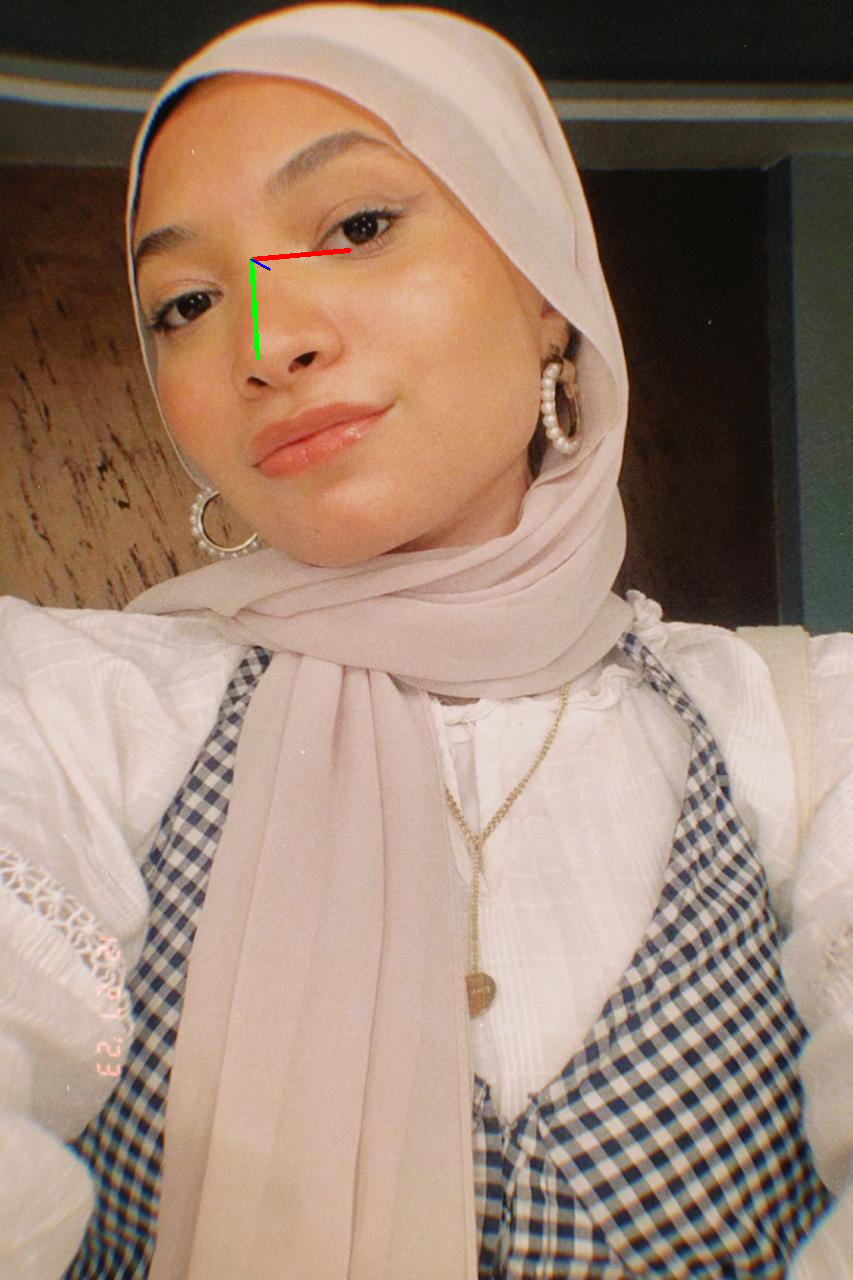

In [27]:
faceModule = mediapipe.solutions.face_mesh
df = pd.DataFrame(columns=[f'mark_{i}' for i in range(1, 937)])
image_path='/content/WhatsApp Image 2024-03-03 at 12.58.13 PM.jpeg'
with faceModule.FaceMesh(static_image_mode=True) as faces:
        image = cv2.imread(image_path)
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
          imagexy=[]
          pointx = []
          pointy = []
          for face in results.multi_face_landmarks:
              for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  shape = image.shape
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  imagexy.append(x)
                  imagexy.append(y)
                  pointx.append(x)
                  pointy.append(y)
                  # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                  # cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
          df = df.append(pd.Series(imagexy, index=df.columns), ignore_index=True)
imgdata=preprocess(df)
x = df.iloc[:, ::2].values
y = df.iloc[:, 1::2].values
tdx=shape[1]*pointx[168]
tdy=shape[0]*pointy[168]
axis=rf.predict(df)
pitch = axis[0,0]
yaw = axis[0,1]
roll = axis[0,2]
cv2_imshow(draw_axis(image,pitch,yaw,roll,tdx=tdx, tdy=tdy))


In [28]:
video_path = "/content/vlc-record-2024-03-03-15h05m57s-vlc-record-2024-03-03-14h47m52s-Best Intro Ever - The Office US.mp4-.mp4-.mp4"
cap = cv2.VideoCapture(video_path)

mp_face_detection = mediapipe.solutions.face_detection
mp_face_mesh = mediapipe.solutions.face_mesh

face_detection = mp_face_detection.FaceDetection()
face_mesh = mp_face_mesh.FaceMesh()

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video_path = "output_video.avi"
output_video = cv2.VideoWriter(output_video_path, fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result_detection = face_detection.process(frame_rgb)
    result_landmarks = face_mesh.process(frame_rgb)

    if result_landmarks.multi_face_landmarks:
        for face_landmarks in result_landmarks.multi_face_landmarks:
            landmarks = []
            for lm in face_landmarks.landmark:
                x, y = (lm.x), (lm.y)
                landmarks.append([x, y])
            landmarks_np = np.array(landmarks)
            x = landmarks_np[:, 0].reshape((1,-1))
            y = landmarks_np[:, 1].reshape((1,-1))
            x_y = np.hstack((x, y))
            x = x_y[:, :468]
            y = x_y[:, 468:]
            x_normalized = ((x - np.min(x, axis=1, keepdims=True)) / (np.max(x, axis=1, keepdims=True) - np.min(x, axis=1, keepdims=True)))
            y_normalized = ((y - np.min(y, axis=1, keepdims=True))  / (np.max(y, axis=1, keepdims=True) - np.min(y, axis=1, keepdims=True)))
            x_y = np.hstack((x_normalized, y_normalized))
            angles = rf.predict(x_y)
            pitch = angles[0,0]
            yaw = angles[0,1]
            roll = angles[0,2]
            draw_axis(frame, pitch, yaw, roll, tdx=x[0,168]*iw, tdy=y[0,168]*ih, size=100)
    output_video.write(frame)
    # cv2_imshow( frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
output_video.release()
cv2.destroyAllWindows()

#trying to normalize data first then split i was trying to avoid data leackage but it ended with an overfitting :"(

In [29]:
normalized_data=preprocess(dfdata)
r_seed = 99
train_data, validation_test_data, labels_train, labels_validation_test = train_test_split(normalized_data, labels, test_size=0.4, random_state=r_seed)
validation_data, test_data, labels_validation, labels_test = train_test_split(validation_test_data, labels_validation_test, test_size=0.5, random_state=r_seed)
print('labels_train.shape = ', labels_train.shape)
print('labels_validation.shape = ', labels_validation.shape)
print('labels_test.shape = ', labels_test.shape)

Normalized x shape: (1853, 468)
Normalized y shape: (1853, 468)
Reconstructed features shape: (1853, 936)
labels_train.shape =  (1111, 3)
labels_validation.shape =  (371, 3)
labels_test.shape =  (371, 3)


In [30]:
lasso_reg = linear_model.Lasso(alpha=0.0001, max_iter=10000)
lasso_reg.fit(train_data, labels_train)
print('LR model Lasso: ')
print('Train : ', lasso_reg.score(train_data, labels_train))
print('Validation : ', lasso_reg.score(validation_data, labels_validation))

LR model Lasso: 
Train :  0.7870901404273661
Validation :  0.28804642684480825


In [31]:
# ## LinearRegression Ridge ##
ridge_reg = Ridge(alpha=0.001, max_iter=10000)
ridge_reg.fit(train_data, labels_train)
print('LR model Ridge: ')
print('Train : ', ridge_reg.score(train_data, labels_train))
print('Validation : ', ridge_reg.score(validation_data, labels_validation))

LR model Ridge: 
Train :  0.8630947432306447
Validation :  0.27790358952391564


In [32]:
# ## ElasticNet Model ##
alpha = 0.001  # regularization strength
l1_ratio = 0.05  # mixing parameter for L1 and L2 penalties
elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=r_seed)
elastic_net.fit(train_data, labels_train)
print('Elastic Net model : ')
print('Train : ', elastic_net.score(train_data, labels_train))
print('Validation : ', elastic_net.score(validation_data, labels_validation))

Elastic Net model : 
Train :  0.7784943779514429
Validation :  0.2804399058681815


In [33]:
# ## Decision Tree ##
decTree = DecisionTreeRegressor(max_depth=30, min_samples_split=10, min_samples_leaf=10, random_state=r_seed)
decTree.fit(train_data, labels_train)
print('Decision Tree model : ')
print('Train : ', decTree.score(train_data, labels_train))
print('Validation : ', decTree.score(validation_data, labels_validation))


Decision Tree model : 
Train :  0.8311812497224714
Validation :  0.22749504818672642


In [34]:
# ## Random Forest ##
rf = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, random_state=r_seed)
rf.fit(train_data, labels_train)
print('Random Forest model : ')
print('Train : ', rf.score(train_data, labels_train))
print('Validation : ', rf.score(validation_data, labels_validation))

Random Forest model : 
Train :  0.9647751045070754
Validation :  0.26858806146565173


#testing all models on test data

In [35]:
models = [lasso_reg, ridge_reg, elastic_net, rf, decTree]
for model in models:
    print(f'{model} Model\n')
    print('Test accuarcy : ', model.score(test_data, labels_test))
    print('_' * 100)

Lasso(alpha=0.0001, max_iter=10000) Model

Test accuarcy :  0.6613818914397571
____________________________________________________________________________________________________
Ridge(alpha=0.001, max_iter=10000) Model

Test accuarcy :  0.6875414197701407
____________________________________________________________________________________________________
ElasticNet(alpha=0.001, l1_ratio=0.05, random_state=99) Model

Test accuarcy :  0.655251525734266
____________________________________________________________________________________________________
RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=99) Model

Test accuarcy :  0.6713191986487977
____________________________________________________________________________________________________
DecisionTreeRegressor(max_depth=30, min_samples_leaf=10, min_samples_split=10,
                      random_state=99) Model

Test accuarcy :  0.5465069283988542
_________________________________________________________________________

Normalized x shape: (1, 468)
Normalized y shape: (1, 468)
Reconstructed features shape: (1, 936)


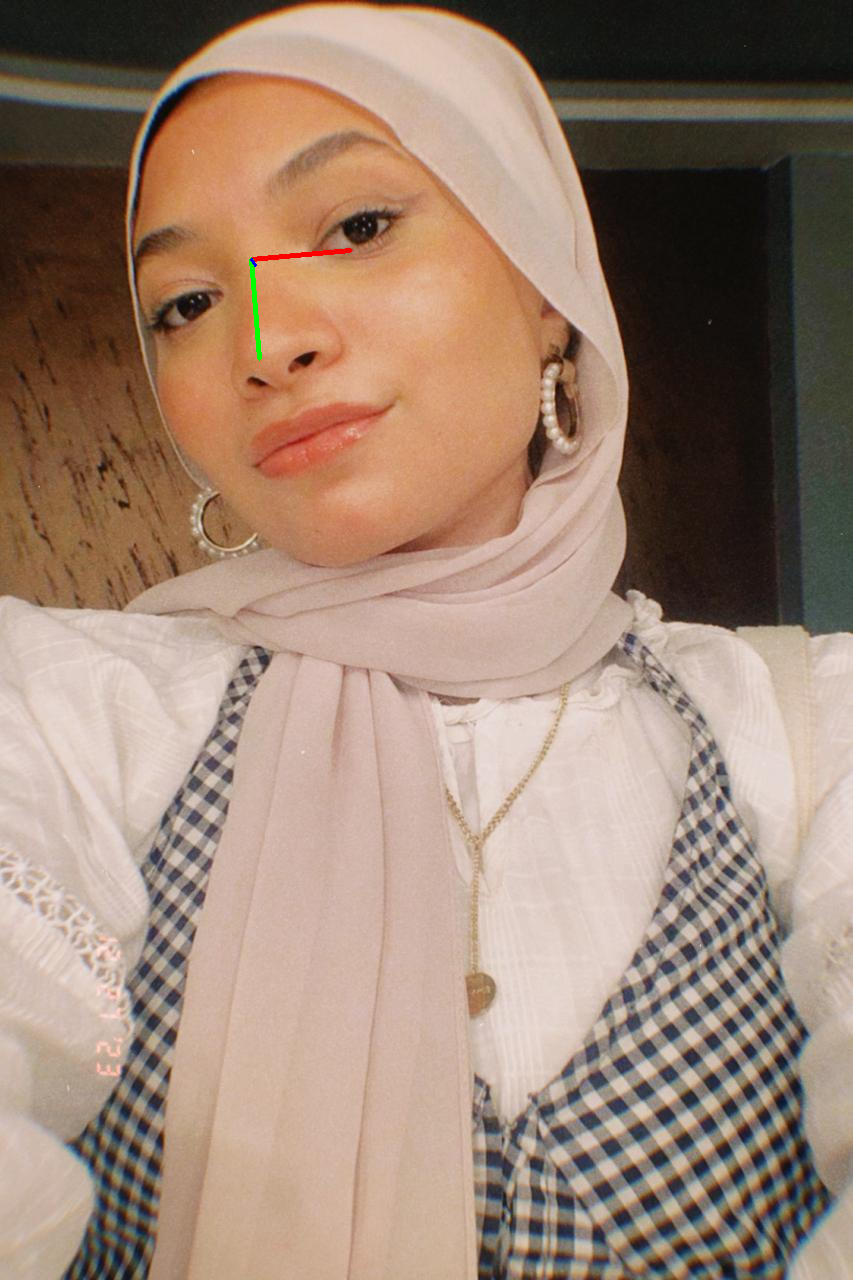

In [36]:
faceModule = mediapipe.solutions.face_mesh
df = pd.DataFrame(columns=[f'mark_{i}' for i in range(1, 937)])
image_path='/content/WhatsApp Image 2024-03-03 at 12.58.13 PM.jpeg'
with faceModule.FaceMesh(static_image_mode=True) as faces:
        image = cv2.imread(image_path)
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
          imagexy=[]
          pointx = []
          pointy = []
          for face in results.multi_face_landmarks:
              for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  shape = image.shape
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  imagexy.append(x)
                  imagexy.append(y)
                  pointx.append(x)
                  pointy.append(y)
                  # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                  # cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
          df = df.append(pd.Series(imagexy, index=df.columns), ignore_index=True)
imgdata=preprocess(df)
x = df.iloc[:, ::2].values
y = df.iloc[:, 1::2].values
tdx=shape[1]*pointx[168]
tdy=shape[0]*pointy[168]
axis=rf.predict(df)
pitch = axis[0,0]
yaw = axis[0,1]
roll = axis[0,2]
cv2_imshow(draw_axis(image,pitch,yaw,roll,tdx=tdx, tdy=tdy))


In [37]:
video_path = "/content/vlc-record-2024-03-03-15h05m57s-vlc-record-2024-03-03-14h47m52s-Best Intro Ever - The Office US.mp4-.mp4-.mp4"
cap = cv2.VideoCapture(video_path)

mp_face_detection = mediapipe.solutions.face_detection
mp_face_mesh = mediapipe.solutions.face_mesh

face_detection = mp_face_detection.FaceDetection()
face_mesh = mp_face_mesh.FaceMesh()

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video_path = "output_video.avi"
output_video1 = cv2.VideoWriter(output_video_path, fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result_detection = face_detection.process(frame_rgb)
    result_landmarks = face_mesh.process(frame_rgb)

    if result_landmarks.multi_face_landmarks:
        for face_landmarks in result_landmarks.multi_face_landmarks:
            landmarks = []
            for lm in face_landmarks.landmark:
                x, y = (lm.x), (lm.y)
                landmarks.append([x, y])
            landmarks_np = np.array(landmarks)
            x = landmarks_np[:, 0].reshape((1,-1))
            y = landmarks_np[:, 1].reshape((1,-1))
            x_y = np.hstack((x, y))
            x = x_y[:, :468]
            y = x_y[:, 468:]
            x_normalized = ((x - np.min(x, axis=1, keepdims=True)) / (np.max(x, axis=1, keepdims=True) - np.min(x, axis=1, keepdims=True)))
            y_normalized = ((y - np.min(y, axis=1, keepdims=True))  / (np.max(y, axis=1, keepdims=True) - np.min(y, axis=1, keepdims=True)))
            x_y = np.hstack((x_normalized, y_normalized))
            angles = rf.predict(x_y)
            pitch = angles[0,0]
            yaw = angles[0,1]
            roll = angles[0,2]
            draw_axis(frame, pitch, yaw, roll, tdx=x[0,168]*iw, tdy=y[0,168]*ih, size=100)
    output_video1.write(frame)
    # cv2_imshow( frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
output_video.release()
cv2.destroyAllWindows()

#Trying cross validation to avoid over fitting

In [38]:
from sklearn.model_selection import KFold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=r_seed)
lasso_train_scores = []
lasso_val_scores = []
ridge_train_scores = []
ridge_val_scores = []
elastic_net_train_scores = []
elastic_net_val_scores = []
random_forest_train_scores = []
random_forest_val_scores = []
dt_train_scores = []
dt_val_scores = []
rf_train_scores = []
rf_val_scores = []
normalized_data=dfdata
normalized_data = pd.DataFrame(normalized_data)
print(labels.shape)
labels = pd.DataFrame(labels)
for train_index, val_index in kf.split(dfdata):
    features_train, features_validation = dfdata.iloc[train_index], dfdata.iloc[val_index]
    labels_train, labels_validation = labels.iloc[train_index], labels.iloc[val_index]

for train_index, val_index in kf.split(dfdata, labels):
    features_train, features_validation = dfdata.iloc[train_index], dfdata.iloc[val_index]
    labels_train, labels_validation = labels.iloc[train_index], labels.iloc[val_index]

    lasso_reg_kfold = linear_model.Lasso(alpha=0.0001,  max_iter=10000)
    lasso_reg_kfold.fit(features_train, labels_train)
    lasso_train_scores.append(lasso_reg_kfold.score(features_train, labels_train))
    lasso_val_scores.append(lasso_reg_kfold.score(features_validation, labels_validation))
    ridge_reg_kfold = Ridge(alpha=0.001, max_iter=10000)
    ridge_reg_kfold.fit(features_train, labels_train)
    ridge_train_scores.append(ridge_reg_kfold.score(features_train, labels_train))
    ridge_val_scores.append(ridge_reg_kfold.score(features_validation, labels_validation))

    alpha = 0.001
    l1_ratio = 0.05
    elastic_net_kfold = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=r_seed)
    elastic_net_kfold.fit(features_train, labels_train)
    elastic_net_train_scores.append(elastic_net_kfold.score(features_train, labels_train))
    elastic_net_val_scores.append(elastic_net_kfold.score(features_validation, labels_validation))
    dt_regressor_kfold = DecisionTreeRegressor(max_depth=20, min_samples_split=10, min_samples_leaf=10, random_state=r_seed)
    dt_regressor_kfold.fit(features_train, labels_train)
    dt_train_scores.append(dt_regressor_kfold.score(features_train, labels_train))
    dt_val_scores.append(dt_regressor_kfold.score(features_validation, labels_validation))
    rf_kfold  = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, random_state=r_seed)
    # rf_kfold.fit(features_train, labels_train)
    # rf_train_scores.append(rf_kfold.score(features_train, labels_train))
    # rf_val_scores.append(rf_kfold.score(features_validation, labels_validation))

print('Average Train Scores:')
print('Lasso:', np.mean(lasso_train_scores))
print('Ridge:', np.mean(ridge_train_scores))
print('Elastic Net:', np.mean(elastic_net_train_scores))
print('Decision Tree:', np.mean(dt_train_scores))
# print('Random forest :', np.mean(rf_train_scores))
print('=' * 50)
print('Average Validation Scores:')
print('Lasso:', np.mean(lasso_val_scores))
print('Ridge:', np.mean(ridge_val_scores))
print('Elastic Net:', np.mean(elastic_net_val_scores))
print('Decision Tree:', np.mean(dt_val_scores))
# print('Random forest:', np.mean(rf_val_scores))


(1853, 3)
Average Train Scores:
Lasso: 0.5239397224159391
Ridge: 0.6491462091991501
Elastic Net: 0.5089877995123591
Decision Tree: 0.5357032428600835
Average Validation Scores:
Lasso: 0.5337781218056736
Ridge: 0.404125934198147
Elastic Net: 0.5347594403973227
Decision Tree: 0.35444309399814494


#Saving all models

In [39]:
joblib.dump(lasso_reg, 'lasso_reg_model.pkl')
joblib.dump(ridge_reg, 'ridge_reg.pkl')
joblib.dump(elastic_net, 'elastic_net.pkl')
joblib.dump(rf, 'random_forest.pkl')
joblib.dump(decTree, 'decTree.pkl')

['decTree.pkl']